# My introduction to deep learning and keras library

In [1]:
%matplotlib inline
# %matplotlib notebook

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

plt.style.use("seaborn-v0_8-poster")
sns.set_theme(context='talk', style='darkgrid')  # dobre do wykresów, ale psuje plt.imshow()
# tf.debugging.set_log_device_placement(True)

# GPU Test
https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth

**Limiting GPU memory growth**
(...)
The second method is to configure a virtual GPU device with tf.config.set_logical_device_configuration and set a hard limit on the total memory to allocate on the GPU.
```python
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
```
This is useful if you want to truly bound the amount of GPU memory available to the TensorFlow process. **This is common practice for local development when the GPU is shared with other applications such as a workstation GUI.**

In [2]:
print(np.__version__)
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

1.24.2
2.10.1
Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
# tf.debugging.set_log_device_placement(True)  # <-- enable this to view logs

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)
# with tf.device('/CPU:0'):

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


# Simple MNIST convnet
https://keras.io/examples/vision/mnist_convnet/

### EDA

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

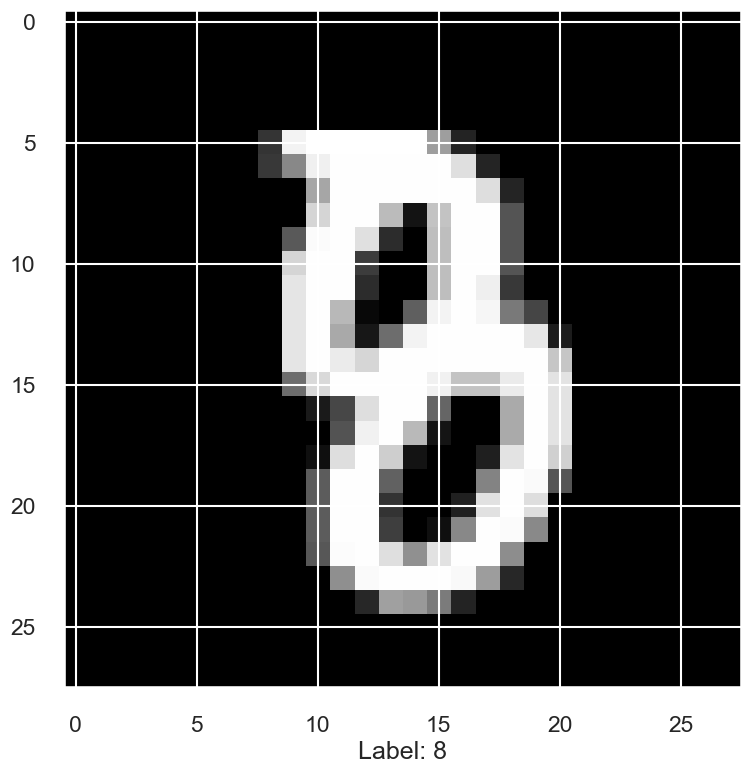

In [9]:
i = np.random.randint(0, y_train.shape[0])
plt.imshow(x_train[i],cmap='gray')
plt.xlabel(f"Label: {y_train[i]}", fontsize=18)
plt.show()

In [10]:
dict(zip(*np.unique(y_train, return_counts=True)))

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

### Prepare the data

In [11]:
# Model parameters
n_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# One hot encoding
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Build the model

In [12]:
model = keras.Sequential([keras.Input(shape=input_shape)])
model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(n_classes, activation="softmax"))

model.summary()
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='/tmp/model_1.png', show_shapes=True)
# tf.keras.utils.plot_model(model, to_file='/tmp/model_1.png', show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

### Train the model

In [13]:
batch_size = 128
epochs = 15  # 15

optimizer = keras.optimizers.Adam()  # learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
loss = keras.losses.CategoricalCrossentropy()  # from_logits=False, label_smoothing=0.0,
# Accuracy: Calculates how often predictions equal labels
# metrics = [keras.metrics.Accuracy()]  -- UWAGA, nie działa

model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)  # why 0.1?

Epoch 1/15
422/422 [==============================] - 3s 4ms/step - loss: 0.3687 - accuracy: 0.8869 - val_loss: 0.0787 - val_accuracy: 0.9778
Epoch 2/15
422/422 [==============================] - 1s 3ms/step - loss: 0.1107 - accuracy: 0.9660 - val_loss: 0.0599 - val_accuracy: 0.9837
Epoch 3/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0828 - accuracy: 0.9735 - val_loss: 0.0520 - val_accuracy: 0.9857
Epoch 4/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0708 - accuracy: 0.9779 - val_loss: 0.0414 - val_accuracy: 0.9883
Epoch 5/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0604 - accuracy: 0.9810 - val_loss: 0.0414 - val_accuracy: 0.9873
Epoch 6/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0547 - accuracy: 0.9826 - val_loss: 0.0359 - val_accuracy: 0.9897
Epoch 7/15
422/422 [==============================] - 2s 5ms/step - loss: 0.0510 - accuracy: 0.9838 - val_loss: 0.0345 - val_accuracy: 0.9900
Epoch 

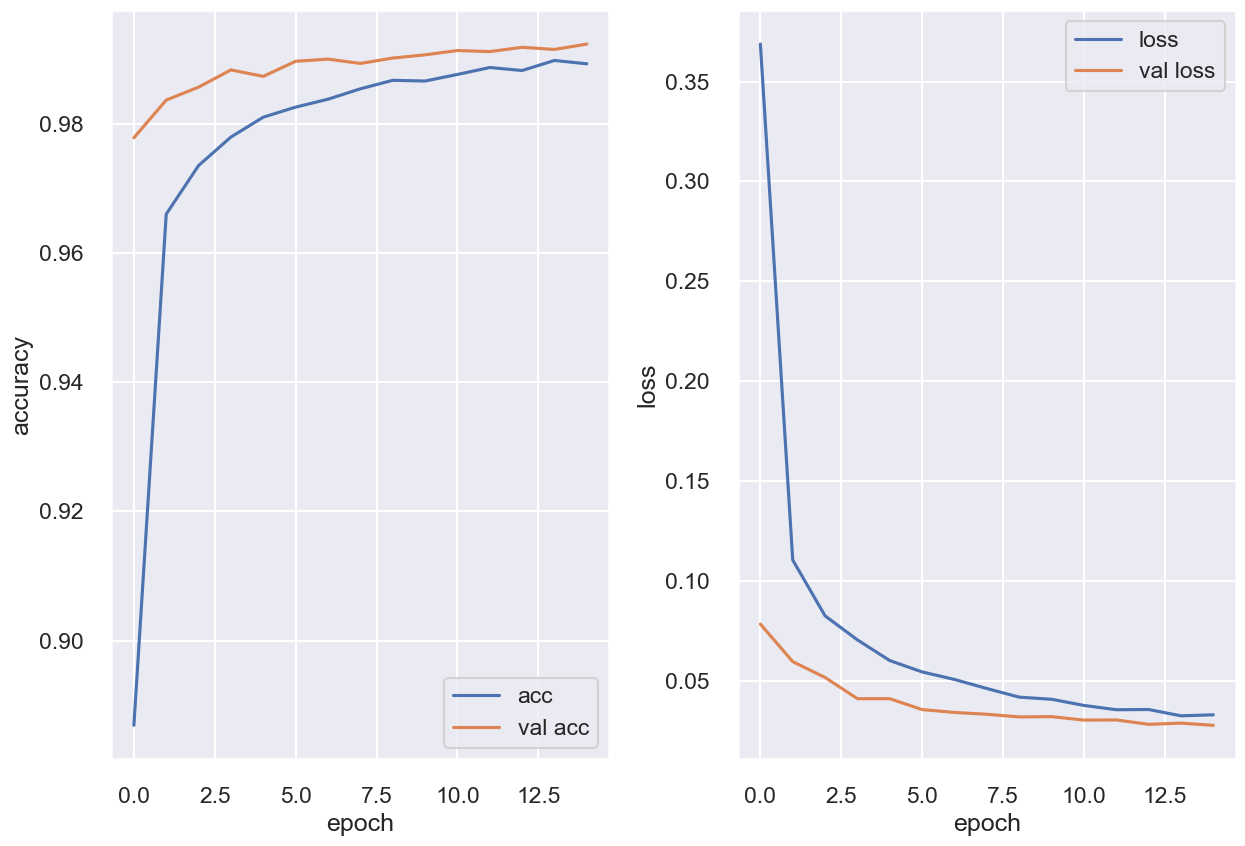

In [14]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluate the model

In [15]:
score = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 - 1s - loss: 0.0244 - accuracy: 0.9927 - 647ms/epoch - 2ms/step
Test loss: 0.024388136342167854
Test accuracy: 0.9926999807357788


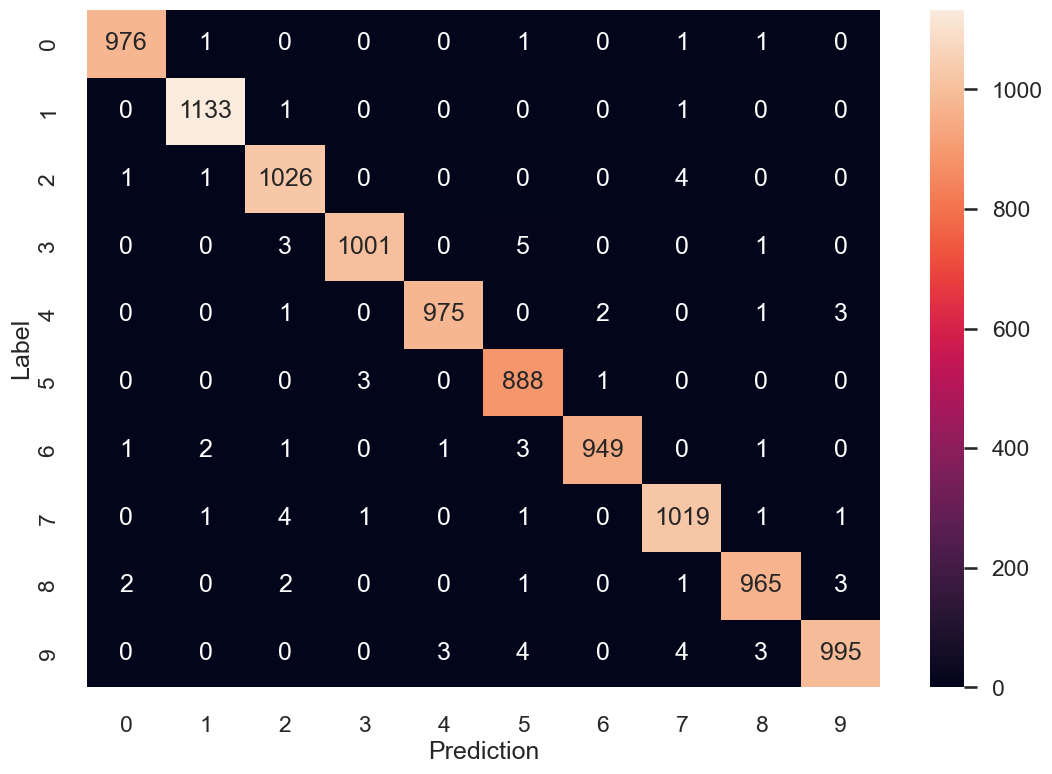

In [16]:
true_class = tf.argmax(y_test, 1)
predicted_class = tf.argmax(model.predict(x_test, verbose=0), 1)
cm = tf.math.confusion_matrix(labels=true_class, predictions=predicted_class)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [17]:
## Sanity Check
# pred = []
# true = []
# p = tf.argmax(model.predict(x_test, verbose=0), 1)
# for ind, n in enumerate(tf.argmax(y_test, 1)):
#     if p.numpy()[ind] != n.numpy():
#         pred.append(p.numpy()[ind])
#         true.append(n.numpy())
# tuples, counts = np.unique(list(zip(pred,true)), axis=0, return_counts=True)
# list(zip(tuples, counts))
## list(zip(pred,true)).count((7, 3))

### Sample Predictions

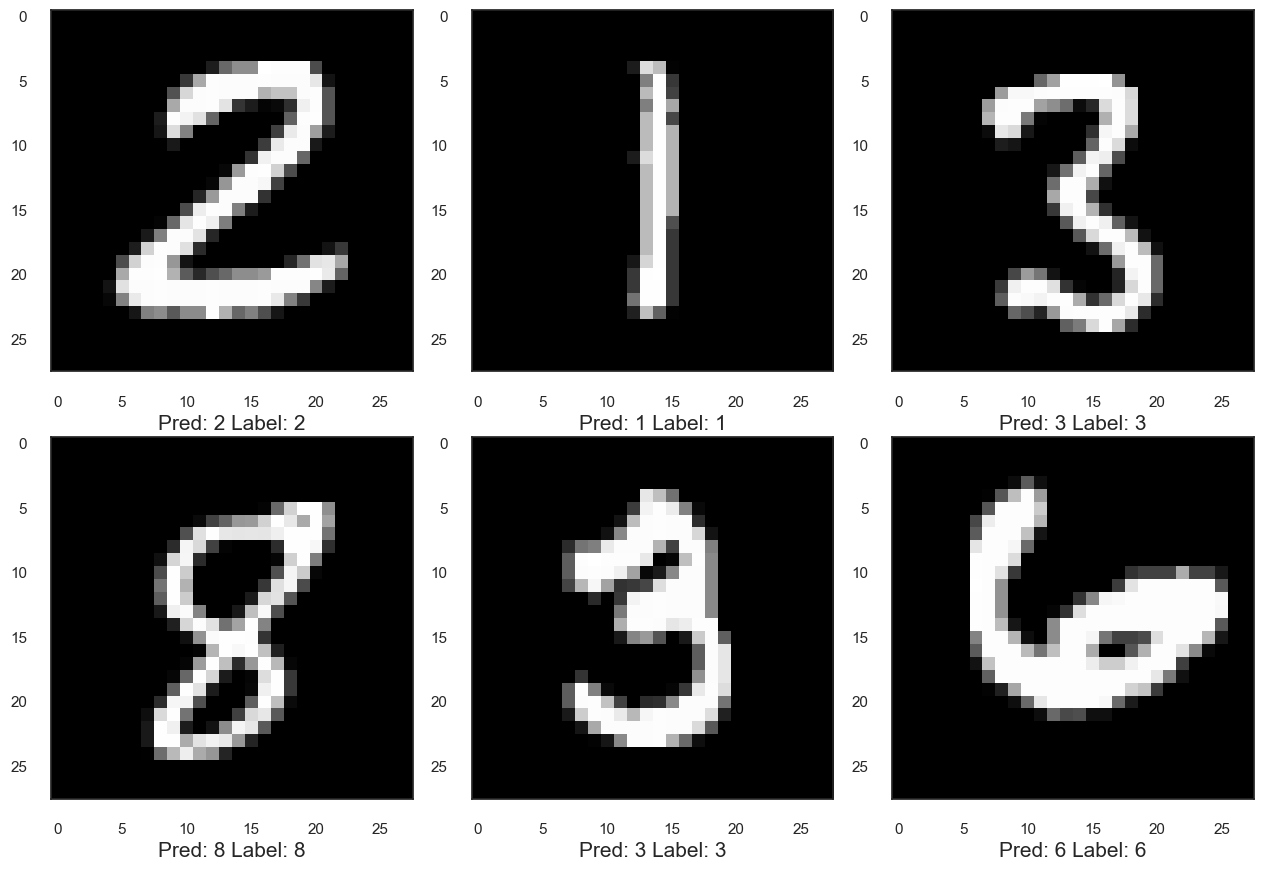

In [18]:
sns.set_theme(style="white", palette=None)
# fig = plt.figure()
sample = np.random.randint(0, y_test.shape[0], 6)
for ind, i in enumerate(sample):
    y = model.predict(np.expand_dims(x_test[i],0), verbose=0)
    plt.subplot(2,3, ind+1)
    plt.imshow(x_test[i], cmap='gray')
    plt.xlabel(f"Pred: {np.argmax(y)} Label: {np.argmax(y_test[i])}", fontsize=15)
plt.tight_layout()
plt.show()

In [19]:
# Jak się dobrać do wag między dowolnymi warstwami?
# Jak zobaczyć wartości neuronów dowolnej warstwy dla konkretnego inputu(zdjęcia)?
# Jak się dostać do modelu z danej epoki? Da się w ogóle czy trzeba samemu zapisywać model podczas treningu?